In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import openpyxl
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report, precision_score, recall_score,f1_score,confusion_matrix,ConfusionMatrixDisplay, roc_curve,roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import  make_scorer
from sklearn.model_selection import GridSearchCV
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

ModuleNotFoundError: No module named 'lightgbm'

Using the same preprocessing used in the classification predictor

In [2]:
os.chdir('H:\PRA')
pd.set_option('display.max_columns',None)
df = pd.read_excel('SampleDonorData2.xlsx',sheet_name = 'Project Data')

In [3]:
df.shape

(19971, 29)

**Data Preprocessing similar to the PART A Classification:**

In [14]:
def apply_all_preprocessing_a(df):
    


    df.columns = map(str.lower,df.columns)


    df_duplicated = df[df.duplicated(['control_number'],keep = False)]

    df_clean = df.copy()
    df_clean = df_clean.drop_duplicates(subset='control_number',keep='first')

    df_duplicated_join = df_duplicated.groupby('control_number').agg({'months_since_last_prom_resp':'nunique','months_since_origin':'nunique' }).reset_index()

    df_duplicated_join.rename(columns={'months_since_last_prom_resp': 'multi_months_since_last_prom_resp', 'months_since_origin':'multi_months_since_origin'}, inplace=True)

    df = df_clean.merge(df_duplicated_join, on ='control_number', how= 'left')



    df.loc[df.last_gift_amt<0,'last_gift_amt'] = -(df.last_gift_amt)
    df.loc[df.months_since_last_prom_resp<0,'last_gift_amt'] = -(df.months_since_last_prom_resp)

    df.multi_months_since_last_prom_resp.fillna(value=-1000,inplace=True)
    df.multi_months_since_origin.fillna(value=-1000,inplace=True)

    df1 = df.copy()


    df1.loc[df1.donor_age<16, 'donor_age'] = -100

    #df1['donor_age'].fillna(value = -1000,inplace=True)

    df1['income_group'].fillna(value = -1000,inplace=True)


    df1.loc[(df1.cluster_code>=0) & (df1.cluster_code<=10),'cluster_code_new']= 'cluster_code_0to10'
    df1.loc[(df1.cluster_code>10) & (df1.cluster_code<=20),'cluster_code_new']= 'cluster_code_11to20'
    df1.loc[(df1.cluster_code>20) & (df1.cluster_code<=30),'cluster_code_new']= 'cluster_code_21to30'
    df1.loc[(df1.cluster_code>30) & (df1.cluster_code<=40),'cluster_code_new']= 'cluster_code_31to40'
    df1.loc[(df1.cluster_code>40) & (df1.cluster_code<=50),'cluster_code_new']= 'cluster_code_41to50'
    df1.loc[(df1.cluster_code>50) ,'cluster_code_new']= 'cluster_code_51+'
    df1.loc[(df1.cluster_code_new.isnull()) | (df1.cluster_code_new == 'nan'),'cluster_code_new'] = 'cluster_code_missing'

    df1['recency_freq_status_cat'] = df1.recency_freq_status.str[0]


    cat_columns = ['urbanicity','home_owner','recency_freq_status_cat','donor_gender','cluster_code_new']
    df_categoried = pd.get_dummies(df1,prefix_sep='_', columns = cat_columns)


    drop_columns = ['recency_freq_status','wealth_rating','cluster_code']

    df_categoried.drop(drop_columns,inplace=True,axis=1)

    #  Using the same value as in training dataset
    df_categoried['months_since_last_prom_resp'].fillna(value=18.0,inplace=True)


    df_categoried['last_gift_amt'].fillna(value=20.0,inplace=True)

#     df_dollar_var = df_categoried[['control_number','target_d6','target_d12','target_d18','target_d24']]

#     drop_dollar = ['target_d6','target_d12','target_d18','target_d24']

#     df_final = df_categoried.drop(drop_dollar, axis=1)

    df_final = df_categoried.copy()
    
    df_final_cal_age = df_final.copy()


    df_final_cal_age.loc[df_final_cal_age.donor_age >0, 'donor_age_cal'] = df_final_cal_age.donor_age
    del df_final_cal_age['donor_age']
 
    df_temp_knn_age = df_final_cal_age[['donor_age_cal','median_home_value','in_house',
                  'median_household_income','pep_star',
                  'published_phone','urbanicity_?','urbanicity_?','urbanicity_C','urbanicity_R','urbanicity_T','urbanicity_U']]
 
    imputed_data = prediction_knn.transform(df_temp_knn_age)
    df_temp = pd.DataFrame(imputed_data)
    df_temp.rename(columns={0:'age',12:'imputed'},inplace=True)
    df_final_cal_age['donor_age_cal'] = df_temp['age'] 
    #df_final_cal_age['imputed_age'] = df_temp['imputed'] 
    
    col_to_standardize = ['months_since_origin',
    'number_of_resp',
    'donor_age_cal',
    'income_group',
    'published_phone',
    'median_home_value',
    'median_household_income',
    'pct_owner_occupied',
    'months_since_last_prom_resp',
    'last_gift_amt',
    'number_prom_12',
    'months_since_last_gift',
    'months_since_first_gift',
    'multi_months_since_last_prom_resp',
    'multi_months_since_origin'
    ]


    df_final_cal_age[col_to_standardize] = prediction_standardization.transform(df_final_cal_age[col_to_standardize])

    return df_final_cal_age

**Loading previous imputer, standardization, and 2 prediction models (f1 and recall based)**

In [6]:
with open('xgboost_2age_standardization.pkl', 'rb') as f:
    prediction_standardization = pickle.load(f)

with open('xgboost_imputer_knn_age.pkl', 'rb') as f:
    prediction_knn = pickle.load(f)    
    
with open('catboost_age_impute_f1.pkl', 'rb') as f:
    prediction_model_f1 = pickle.load(f)

with open('catboost_age_impute_best_recall.pkl', 'rb') as f:
    prediction_model_recall = pickle.load(f)

In [15]:
df_final = apply_all_preprocessing_a(df)

C:\Users\GC\AppData\Local\Temp\ipykernel_49292\3875276361.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'cluster_code_0to10' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.loc[(df1.cluster_code>=0) & (df1.cluster_code<=10),'cluster_code_new']= 'cluster_code_0to10'
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: Fut

In [16]:
df_final

,target_b,target_d6,target_d12,target_d18,target_d24,control_number,months_since_origin,number_of_resp,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing,donor_age_cal
0,0,0.0,0.0,0.0,0.0,6875,0.831414,0.453214,1,0.546004,0.999419,0.494747,0.480714,-1.125839,1,0,0.400,-0.282099,0.086290,0.453214,-0.297693,1.564910,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,-1.197229
1,0,0.0,0.0,0.0,0.0,8384,-0.214553,4.345523,1,-1.848325,-1.000581,-0.798717,-1.087497,0.430298,1,0,0.000,-0.214988,-0.056787,4.345523,-2.768160,-0.332395,-0.162146,-0.162146,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,-1.197229
2,0,0.0,0.0,0.0,0.0,8863,-0.388881,0.669453,1,0.543624,-1.000581,0.236262,-0.193981,-0.668152,0,0,0.167,-0.080765,-0.056787,0.669453,0.443447,-0.332395,-0.162146,-0.162146,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,-1.197229
3,0,0.0,0.0,0.0,0.0,10001,-0.388881,4.345523,0,-1.848325,-1.000581,-0.419813,-0.388488,-2.361595,1,1,0.125,-0.214988,-0.056787,4.345523,-0.050646,-0.466008,-0.162146,-0.162146,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,-1.197229
4,0,0.0,0.0,0.0,0.0,14064,-0.911864,3.264326,1,0.546004,-1.000581,-0.166518,1.076392,0.704910,0,0,0.000,-0.282099,-0.018936,3.264326,0.443447,-1.321132,-0.162146,-0.162146,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,-1.197229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19367,1,275.0,725.0,1125.0,1325.0,138552,0.308431,-0.195504,0,0.541244,0.999419,-0.486251,-0.321626,0.750679,1,0,0.000,-0.147876,-0.041647,-0.195504,0.196400,0.816677,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,1.148616
19368,0,0.0,0.0,0.0,0.0,138632,0.831414,-0.411744,0,0.538864,0.999419,-0.419813,-0.807894,-0.164696,1,0,0.167,-0.080765,-0.041647,-0.411744,0.443447,1.511465,-0.162146,-0.162146,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,1.148616
19369,1,250.0,550.0,825.0,925.0,139074,0.134103,0.020735,0,0.546004,0.999419,-0.410470,-0.886912,0.155685,0,0,0.200,-0.080765,-0.056787,0.020735,0.443447,0.602896,-0.162146,-0.162146,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,1.148616
19370,0,0.0,0.0,0.0,0.0,141629,0.657086,0.020735,0,0.541244,-1.000581,-0.544384,-1.105732,-1.491989,1,0,0.000,-0.282099,0.143422,0.020735,-

In the above, the **dollar variables** are not standardized yet

# future Values need to be predicted using new targeting strategy:

Adding prediction y_pred_f1 from the previous part A model (catboost_age_impute_f1)

Adding prediction y_pred_r from the previous part A model (prediction_model_recall)

I will keep only the new rows that have **y_pred_f1 = 1** for the **first approach** and **y_pred_r = 1** for the **second approach**
(This is done as only those users would be targetted)


In [21]:
y_pred_f1 = prediction_model_f1.best_estimator_.predict(df_final.drop(columns =['control_number','target_d6','target_d12','target_d18','target_d24','target_b']))
y_pred_r = prediction_model_recall.best_estimator_.predict(df_final.drop(columns =['control_number','target_d6','target_d12','target_d18','target_d24','target_b']))

In [23]:
df_final['y_pred_f1'] = pd.Series(y_pred_f1)
df_final['y_pred_r'] = pd.Series(y_pred_r)

In [24]:
df_final

,target_b,target_d6,target_d12,target_d18,target_d24,control_number,months_since_origin,number_of_resp,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing,donor_age_cal,y_pred_f1,y_pred_r
0,0,0.0,0.0,0.0,0.0,6875,0.831414,0.453214,1,0.546004,0.999419,0.494747,0.480714,-1.125839,1,0,0.400,-0.282099,0.086290,0.453214,-0.297693,1.564910,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,-1.197229,0,0
1,0,0.0,0.0,0.0,0.0,8384,-0.214553,4.345523,1,-1.848325,-1.000581,-0.798717,-1.087497,0.430298,1,0,0.000,-0.214988,-0.056787,4.345523,-2.768160,-0.332395,-0.162146,-0.162146,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,-1.197229,0,1
2,0,0.0,0.0,0.0,0.0,8863,-0.388881,0.669453,1,0.543624,-1.000581,0.236262,-0.193981,-0.668152,0,0,0.167,-0.080765,-0.056787,0.669453,0.443447,-0.332395,-0.162146,-0.162146,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,-1.197229,0,0
3,0,0.0,0.0,0.0,0.0,10001,-0.388881,4.345523,0,-1.848325,-1.000581,-0.419813,-0.388488,-2.361595,1,1,0.125,-0.214988,-0.056787,4.345523,-0.050646,-0.466008,-0.162146,-0.162146,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,-1.197229,0,0
4,0,0.0,0.0,0.0,0.0,14064,-0.911864,3.264326,1,0.546004,-1.000581,-0.166518,1.076392,0.704910,0,0,0.000,-0.282099,-0.018936,3.264326,0.443447,-1.321132,-0.162146,-0.162146,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,-1.197229,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19367,1,275.0,725.0,1125.0,1325.0,138552,0.308431,-0.195504,0,0.541244,0.999419,-0.486251,-0.321626,0.750679,1,0,0.000,-0.147876,-0.041647,-0.195504,0.196400,0.816677,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,1.148616,1,1
19368,0,0.0,0.0,0.0,0.0,138632,0.831414,-0.411744,0,0.538864,0.999419,-0.419813,-0.807894,-0.164696,1,0,0.167,-0.080765,-0.041647,-0.411744,0.443447,1.511465,-0.162146,-0.162146,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,1.148616,1,1
19369,1,250.0,550.0,825.0,925.0,139074,0.134103,0.020735,0,0.546004,0.999419,-0.410470,-0.886912,0.155685,0,0,0.200,-0.080765,-0.056787,0.020735,0.443447,0.602896,-0.162146,-0.162146,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,1.148616,1,1
19370,0,0.0,0.0,0.0,0.0,141629,0.657086,0.020735,0,0.541244,-1.000581,-0.544384,

In [27]:
print('total rows: ',df_final.shape[0])
print('total donations: ',df_final.target_b.sum())
print('total prediction donations from f1 model: ',df_final.y_pred_f1.sum())
print('total prediction donations from recall model: ',df_final.y_pred_r.sum())

total rows:  19372
total donations:  969
total prediction donations from f1 model:  3950
total prediction donations from recall model:  12459


The above aligns with the summary results from part A 

#  First approach: Targeting 3950 users 
using F1 model

In [28]:
df_f1 = df_final.copy()

In [29]:
df_f1

,target_b,target_d6,target_d12,target_d18,target_d24,control_number,months_since_origin,number_of_resp,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing,donor_age_cal,y_pred_f1,y_pred_r
0,0,0.0,0.0,0.0,0.0,6875,0.831414,0.453214,1,0.546004,0.999419,0.494747,0.480714,-1.125839,1,0,0.400,-0.282099,0.086290,0.453214,-0.297693,1.564910,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,-1.197229,0,0
1,0,0.0,0.0,0.0,0.0,8384,-0.214553,4.345523,1,-1.848325,-1.000581,-0.798717,-1.087497,0.430298,1,0,0.000,-0.214988,-0.056787,4.345523,-2.768160,-0.332395,-0.162146,-0.162146,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,-1.197229,0,1
2,0,0.0,0.0,0.0,0.0,8863,-0.388881,0.669453,1,0.543624,-1.000581,0.236262,-0.193981,-0.668152,0,0,0.167,-0.080765,-0.056787,0.669453,0.443447,-0.332395,-0.162146,-0.162146,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,-1.197229,0,0
3,0,0.0,0.0,0.0,0.0,10001,-0.388881,4.345523,0,-1.848325,-1.000581,-0.419813,-0.388488,-2.361595,1,1,0.125,-0.214988,-0.056787,4.345523,-0.050646,-0.466008,-0.162146,-0.162146,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,-1.197229,0,0
4,0,0.0,0.0,0.0,0.0,14064,-0.911864,3.264326,1,0.546004,-1.000581,-0.166518,1.076392,0.704910,0,0,0.000,-0.282099,-0.018936,3.264326,0.443447,-1.321132,-0.162146,-0.162146,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,-1.197229,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19367,1,275.0,725.0,1125.0,1325.0,138552,0.308431,-0.195504,0,0.541244,0.999419,-0.486251,-0.321626,0.750679,1,0,0.000,-0.147876,-0.041647,-0.195504,0.196400,0.816677,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,1.148616,1,1
19368,0,0.0,0.0,0.0,0.0,138632,0.831414,-0.411744,0,0.538864,0.999419,-0.419813,-0.807894,-0.164696,1,0,0.167,-0.080765,-0.041647,-0.411744,0.443447,1.511465,-0.162146,-0.162146,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,1.148616,1,1
19369,1,250.0,550.0,825.0,925.0,139074,0.134103,0.020735,0,0.546004,0.999419,-0.410470,-0.886912,0.155685,0,0,0.200,-0.080765,-0.056787,0.020735,0.443447,0.602896,-0.162146,-0.162146,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,1.148616,1,1
19370,0,0.0,0.0,0.0,0.0,141629,0.657086,0.020735,0,0.541244,-1.000581,-0.544384,

**Approach:**
1. Drop target_b, y_pred_r
2. treat dollar variables as y variables target to predict and will use all the other remaining variables as independent variables (x variables)
3. 4 models, each predicting 'target_d6','target_d12','target_d18' and 'target_d24'
4. Using non parameteric regressor models in GRIDSearch (Randomforest, XGboost, catboost, lightGBM)

In [30]:
df_f1 = df_f1[df_f1.y_pred_f1 ==1]


In [32]:
print(df_f1.y_pred_f1.sum())
df_f1

3950


,target_b,target_d6,target_d12,target_d18,target_d24,control_number,months_since_origin,number_of_resp,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing,donor_age_cal,y_pred_f1,y_pred_r
1272,0,0.0,0.0,0.0,0.0,70039,0.831414,0.020735,0,-1.848325,-1.000581,-0.260985,0.669143,0.247223,1,1,0.455,-0.013654,-0.041647,0.020735,0.690494,1.538188,-0.162146,-0.162146,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,-0.852251,1,1
1311,0,0.0,0.0,0.0,0.0,89586,-0.737536,0.453214,0,0.536484,-1.000581,-0.212194,-1.063184,-3.048126,1,0,0.667,-0.416321,-0.056787,0.453214,-0.791786,-0.973738,-0.162146,-0.162146,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,-0.852251,1,1
1323,0,0.0,0.0,0.0,0.0,94433,0.482758,0.236974,0,-1.848325,0.999419,1.961573,-0.315548,-1.308914,1,1,0.273,-0.147876,-0.013637,0.236974,-0.544740,1.164071,-0.162146,-0.162146,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,-0.852251,1,1
1331,0,0.0,0.0,0.0,0.0,100263,-0.737536,-0.195504,0,-1.848325,-1.000581,0.960851,1.817949,1.208366,0,0,0.250,0.523234,-0.041647,-0.195504,-0.050646,-1.000461,-0.162146,-0.162146,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,-0.852251,1,1
1431,0,0.0,0.0,0.0,0.0,152657,-0.388881,0.236974,0,-1.848325,-1.000581,0.790604,0.207189,-0.896996,1,0,0.100,-0.349210,-0.041647,0.236974,-0.544740,-0.492731,-0.162146,-0.162146,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,-0.852251,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19367,1,275.0,725.0,1125.0,1325.0,138552,0.308431,-0.195504,0,0.541244,0.999419,-0.486251,-0.321626,0.750679,1,0,0.000,-0.147876,-0.041647,-0.195504,0.196400,0.816677,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,1.148616,1,1
19368,0,0.0,0.0,0.0,0.0,138632,0.831414,-0.411744,0,0.538864,0.999419,-0.419813,-0.807894,-0.164696,1,0,0.167,-0.080765,-0.041647,-0.411744,0.443447,1.511465,-0.162146,-0.162146,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,1.148616,1,1
19369,1,250.0,550.0,825.0,925.0,139074,0.134103,0.020735,0,0.546004,0.999419,-0.410470,-0.886912,0.155685,0,0,0.200,-0.080765,-0.056787,0.020735,0.443447,0.602896,-0.162146,-0.162146,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,1.148616,1,1
19370,0,0.0,0.0,0.0,0.0,141629,0.657086,0.020735,0,0.541244

In [33]:
df_f1.drop(columns=['target_b','y_pred_r','y_pred_f1'],inplace= True)

C:\Users\GC\AppData\Local\Temp\ipykernel_49292\4032368963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f1.drop(columns=['target_b','y_pred_r','y_pred_f1'],inplace= True)


In [35]:
df_f1

,target_d6,target_d12,target_d18,target_d24,control_number,months_since_origin,number_of_resp,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing,donor_age_cal
1272,0.0,0.0,0.0,0.0,70039,0.831414,0.020735,0,-1.848325,-1.000581,-0.260985,0.669143,0.247223,1,1,0.455,-0.013654,-0.041647,0.020735,0.690494,1.538188,-0.162146,-0.162146,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,-0.852251
1311,0.0,0.0,0.0,0.0,89586,-0.737536,0.453214,0,0.536484,-1.000581,-0.212194,-1.063184,-3.048126,1,0,0.667,-0.416321,-0.056787,0.453214,-0.791786,-0.973738,-0.162146,-0.162146,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,-0.852251
1323,0.0,0.0,0.0,0.0,94433,0.482758,0.236974,0,-1.848325,0.999419,1.961573,-0.315548,-1.308914,1,1,0.273,-0.147876,-0.013637,0.236974,-0.544740,1.164071,-0.162146,-0.162146,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,-0.852251
1331,0.0,0.0,0.0,0.0,100263,-0.737536,-0.195504,0,-1.848325,-1.000581,0.960851,1.817949,1.208366,0,0,0.250,0.523234,-0.041647,-0.195504,-0.050646,-1.000461,-0.162146,-0.162146,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,-0.852251
1431,0.0,0.0,0.0,0.0,152657,-0.388881,0.236974,0,-1.848325,-1.000581,0.790604,0.207189,-0.896996,1,0,0.100,-0.349210,-0.041647,0.236974,-0.544740,-0.492731,-0.162146,-0.162146,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,-0.852251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19367,275.0,725.0,1125.0,1325.0,138552,0.308431,-0.195504,0,0.541244,0.999419,-0.486251,-0.321626,0.750679,1,0,0.000,-0.147876,-0.041647,-0.195504,0.196400,0.816677,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,1.148616
19368,0.0,0.0,0.0,0.0,138632,0.831414,-0.411744,0,0.538864,0.999419,-0.419813,-0.807894,-0.164696,1,0,0.167,-0.080765,-0.041647,-0.411744,0.443447,1.511465,-0.162146,-0.162146,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,1.148616
19369,250.0,550.0,825.0,925.0,139074,0.134103,0.020735,0,0.546004,0.999419,-0.410470,-0.886912,0.155685,0,0,0.200,-0.080765,-0.056787,0.020735,0.443447,0.602896,-0.162146,-0.162146,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,1.148616
19370,0.0,0.0,0.0,0.0,141629,0.657086,0.020735,0,0.541244,-1.000581,-0.544384,-1.105732,-1.491989,1,0,0.000,-0.282099,0.143422,0.020735,-0.297693,1

Split into train and test sets

In [36]:
X = df_f1.drop(columns=['target_d6','target_d12','target_d18','target_d24'])
y_d6 = df_f1['target_d6']
y_d12 = df_f1['target_d12']
y_d18 = df_f1['target_d18']
y_d24 = df_f1['target_d24']

In [40]:
X_train, X_test, y_d6_train, y_d6_test, y_d12_train, y_d12_test, y_d18_train, y_d18_test , y_d24_train, y_d24_test= train_test_split(
    X, y_d6, y_d12, y_d18,y_d24, test_size=0.2, random_state=0
)

In [41]:
print('X_train: ',X_train.shape )
print('X_test: ',X_test.shape )
print('y_d6_train: ',y_d6_train.shape )
print('y_d6_test: ',y_d6_test.shape )
print('y_d12_train: ',y_d12_train.shape )
print('y_d12_test: ',y_d12_test.shape )
print('y_d18_train: ',y_d18_train.shape )
print('y_d18_test: ',y_d18_test.shape )
print('y_d24_train: ',y_d24_train.shape )
print('y_d24_test: ',y_d24_test.shape )


X_train:  (3160, 45)
X_test:  (790, 45)
y_d6_train:  (3160,)
y_d6_test:  (790,)
y_d12_train:  (3160,)
y_d12_test:  (790,)
y_d18_train:  (3160,)
y_d18_test:  (790,)
y_d24_train:  (3160,)
y_d24_test:  (790,)


In [68]:
X_train

,control_number,months_since_origin,number_of_resp,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing,donor_age_cal
17088,127856,0.134103,-0.844222,0,0.541244,0.999419,-0.289013,1.112862,1.162597,1,0,0.286,0.187679,0.261161,-0.844222,1.431634,0.442560,-0.162146,-0.162146,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,1.769575
18572,163178,0.831414,-0.195504,0,-1.848325,-1.000581,1.597202,0.535420,0.796447,1,1,0.000,-0.080765,0.056766,-0.195504,0.443447,1.511465,-0.162146,-0.162146,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,0.638050
9368,16049,-0.388881,-0.411744,0,-1.848325,-1.000581,-0.480022,-0.522212,0.247223,0,0,0.333,-0.147876,-0.041647,-0.411744,0.196400,-0.439286,-0.162146,-0.162146,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,0.527657
14962,93993,0.482758,0.020735,0,-1.848325,-1.000581,0.009958,0.249738,0.796447,1,0,0.222,0.187679,-0.028778,0.020735,1.431634,0.950290,-0.162146,-0.162146,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,-0.038105
13239,53770,0.657086,0.020735,0,-1.848325,0.999419,1.065698,3.106557,1.345672,1,0,0.333,-0.416321,0.068946,0.020735,-0.791786,1.458020,-0.162146,-0.162146,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,0.155082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12016,27504,-0.911864,-0.195504,0,-1.848325,-1.000581,-0.461337,-0.734954,-1.171608,1,0,0.500,-0.349210,-0.056787,-0.195504,-0.544740,-1.428022,-0.162146,-0.162146,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,-0.617667
18186,156959,0.598977,0.020735,0,-1.848325,-1.000581,1.150822,0.152484,-2.453133,1,0,0.091,-0.214988,0.181894,0.020735,-0.050646,-0.118614,-0.162146,-0.162146,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,0.707045
15671,107188,0.657086,0.669453,0,-1.848325,-1.000581,-0.664803,-0.649857,-0.439308,1,1,0.200,-0.214988,-0.056787,0.669453,-0.050646,1.458020,-0.162146,-0.162146,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,0.596653
17205,75247,-0.737536,-0.411744,0,0.538864,0.999419,-0.722936,-0.443193,0.796447,0,0,0.222,0.053457,-0.041647,-0.411744,-0.050646,-0.973738,-0.162146,-0.162146,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,1.838570


In [45]:
models = {
    'rf': RandomForestRegressor(),
    'xgb': XGBRegressor(),
    'lgbm': LGBMRegressor(),
    'cBoost': CatBoostRegressor()
}

In [123]:
param_grid = {
    'rf': {'n_estimators': [50,100,200,250]},
    'xgb': {'n_estimators': [50,100,200,250]},
    'lgbm': {'n_estimators': [50,100,200,250]},
    'cBoost': {'iterations': [200,500,750,1000]}
}

Evaluating the grid search on **neg_mean_absolute_error** (function : metrics.mean_absolute_error)
Chose based on data and the application 

MAE=  average magnitude of the errors in the same units as the target variable

less sensitive to outliers 

distribution of errors is asymmetric

RMSE:it gives more weight to larger errors due to the squaring. Same unit as target variable

In [130]:
model_for_d6 = {}
para_for_d6 = {}
score_for_d6 = {}

In [131]:
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, n_jobs = -1, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train.drop(columns=['control_number']), y_d6_train)
    para_for_d6[name] = grid_search.best_params_
    score_for_d6[name] = grid_search.best_score_
    model_for_d6[name] = grid_search.best_estimator_

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1634
[LightGBM] [Info] Number of data points in the train set: 3160, number of used features: 42
[LightGBM] [Info] Start training from score 51.869630
Learning rate set to 0.086272
0:	learn: 185.6954777	total: 2.07ms	remaining: 1.03s
1:	learn: 185.0355664	total: 3.9ms	remaining: 971ms
2:	learn: 184.3254210	total: 5.63ms	remaining: 933ms
3:	learn: 183.7415080	total: 7.47ms	remaining: 927ms
4:	learn: 183.3916161	total: 9.42ms	remaining: 932ms
5:	learn: 182.9459215	total: 11.2ms	remaining: 923ms
6:	learn: 182.2606396	total: 13ms	remaining: 913ms
7:	learn: 181.7201965	total: 14.8ms	remaining: 912ms
8:	learn: 180.8734828	total: 16.6ms	remaining: 907ms
9:	learn: 180.2487880	total: 18.3ms	remaining: 899ms
10:	learn: 179.4582457	total: 20.1ms	

212:	learn: 133.8313027	total: 381ms	remaining: 513ms
213:	learn: 133.5998804	total: 383ms	remaining: 512ms
214:	learn: 133.4735702	total: 385ms	remaining: 510ms
215:	learn: 133.3334202	total: 387ms	remaining: 509ms
216:	learn: 133.1280452	total: 389ms	remaining: 507ms
217:	learn: 132.8719036	total: 391ms	remaining: 505ms
218:	learn: 132.7119373	total: 393ms	remaining: 504ms
219:	learn: 132.6265153	total: 395ms	remaining: 502ms
220:	learn: 132.4561320	total: 397ms	remaining: 501ms
221:	learn: 132.3416689	total: 399ms	remaining: 499ms
222:	learn: 132.0714093	total: 401ms	remaining: 498ms
223:	learn: 131.8601610	total: 403ms	remaining: 496ms
224:	learn: 131.8181247	total: 404ms	remaining: 494ms
225:	learn: 131.6238449	total: 406ms	remaining: 492ms
226:	learn: 131.4089109	total: 408ms	remaining: 490ms
227:	learn: 131.3525007	total: 409ms	remaining: 488ms
228:	learn: 131.1631506	total: 411ms	remaining: 487ms
229:	learn: 130.9092258	total: 413ms	remaining: 485ms
230:	learn: 130.7629438	tota

437:	learn: 101.2982159	total: 779ms	remaining: 110ms
438:	learn: 101.0743057	total: 781ms	remaining: 109ms
439:	learn: 101.0274939	total: 783ms	remaining: 107ms
440:	learn: 100.9706539	total: 785ms	remaining: 105ms
441:	learn: 100.8731895	total: 786ms	remaining: 103ms
442:	learn: 100.8194424	total: 788ms	remaining: 101ms
443:	learn: 100.6982085	total: 790ms	remaining: 99.7ms
444:	learn: 100.5633265	total: 792ms	remaining: 97.9ms
445:	learn: 100.4263547	total: 794ms	remaining: 96.1ms
446:	learn: 100.2610711	total: 796ms	remaining: 94.3ms
447:	learn: 100.1401166	total: 797ms	remaining: 92.5ms
448:	learn: 100.0523178	total: 799ms	remaining: 90.7ms
449:	learn: 99.9811771	total: 801ms	remaining: 89ms
450:	learn: 99.9410852	total: 802ms	remaining: 87.2ms
451:	learn: 99.8707945	total: 804ms	remaining: 85.4ms
452:	learn: 99.7642527	total: 806ms	remaining: 83.6ms
453:	learn: 99.7023144	total: 808ms	remaining: 81.8ms
454:	learn: 99.4719617	total: 809ms	remaining: 80ms
455:	learn: 99.4449217	tot

In [132]:
score_for_d6

{'rf': -93.00095911392404,
 'xgb': -95.53143841790417,
 'lgbm': -86.87579212029665,
 'cBoost': -87.13283209050225}

In [133]:
para_for_d6

{'rf': {'n_estimators': 100},
 'xgb': {'n_estimators': 50},
 'lgbm': {'n_estimators': 50},
 'cBoost': {'iterations': 500}}

In [134]:
print("RF:")
y_pred_d6 = model_for_d6['rf'].predict(X_test.drop(columns=['control_number']))
print('D6_test_sum: ',y_d6_test.sum())
print('D6_pred_sum: ',y_pred_d6.sum())
print("\tAbsolute difference in D6 Sum:", abs(y_d6_test.sum()-y_pred_d6.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d6_test, y_pred_d6))



print("XGB:")

y_pred_d6 = model_for_d6['xgb'].predict(X_test.drop(columns=['control_number']))
print('D6_test_sum: ',y_d6_test.sum())
print('D6_pred_sum: ',y_pred_d6.sum())
print("\tAbsolute difference in D6 Sum:", abs(y_d6_test.sum()-y_pred_d6.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d6_test, y_pred_d6))

print("lgbm:")
y_pred_d6 = model_for_d6['lgbm'].predict(X_test.drop(columns=['control_number']))
print('D6_test_sum: ',y_d6_test.sum())
print('D6_pred_sum: ',y_pred_d6.sum())
print("\tAbsolute difference in D6 Sum:", abs(y_d6_test.sum()-y_pred_d6.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d6_test, y_pred_d6))


print("cBoost:")
y_pred_d6 = model_for_d6['cBoost'].predict(X_test.drop(columns=['control_number']))
print('D6_test_sum: ',y_d6_test.sum())
print('D6_pred_sum: ',y_pred_d6.sum())
print("\tAbsolute difference in D6 Sum:", abs(y_d6_test.sum()-y_pred_d6.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d6_test, y_pred_d6))

RF:
D6_test_sum:  48819.69
D6_pred_sum:  50370.8166
	Absolute difference in D6 Sum: 1551.126599999996
	Mean absolute error: 102.91149594936711
XGB:
D6_test_sum:  48819.69
D6_pred_sum:  43493.363
	Absolute difference in D6 Sum: 5326.326718750002
	Mean absolute error: 100.70838251177872
lgbm:
D6_test_sum:  48819.69
D6_pred_sum:  41039.36603656873
	Absolute difference in D6 Sum: 7780.32396343127
	Mean absolute error: 95.3221249714295
cBoost:
D6_test_sum:  48819.69
D6_pred_sum:  41910.56047124241
	Absolute difference in D6 Sum: 6909.129528757592
	Mean absolute error: 94.27705959033109


C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

From above, considering **catBoost Regressor** as the best predictor for the d6 target variable

It has the lowest mean_absolute_error

In [180]:
best_d6_model = model_for_d6['cBoost']
best_d6_para = para_for_d6['cBoost']

In [136]:
model_for_d12 = {}
para_for_d12 = {}
score_for_d12 = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, n_jobs = -1, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train.drop(columns=['control_number']), y_d12_train)
    para_for_d12[name] = grid_search.best_params_
    score_for_d12[name] = grid_search.best_score_
    model_for_d12[name] = grid_search.best_estimator_

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1634
[LightGBM] [Info] Number of data points in the train set: 3160, number of used features: 42
[LightGBM] [Info] Start training from score 149.142114
Learning rate set to 0.086272
0:	learn: 498.4257957	total: 1.94ms	remaining: 967ms
1:	learn: 497.2487991	total: 3.58ms	remaining: 891ms
2:	learn: 495.9643529	total: 5.24ms	remaining: 869ms
3:	learn: 493.0609595	total: 6.83ms	remaining: 847ms
4:	learn: 491.1715896	total: 8.47ms	remaining: 839ms
5:	learn: 490.1712060	total: 10.1ms	remaining: 836ms
6:	learn: 488.4228930	total: 11.8ms	remaining: 829ms
7:	learn: 486.4917542	total: 13.4ms	remaining: 824ms
8:	learn: 484.7784439	total: 15ms	remaining: 817ms
9:	learn: 482.3342316	total: 16.7ms	remaining: 817ms
10:	learn: 481.4411750	total: 18.3m

214:	learn: 360.4733810	total: 389ms	remaining: 515ms
215:	learn: 359.9553700	total: 391ms	remaining: 514ms
216:	learn: 359.1597243	total: 393ms	remaining: 513ms
217:	learn: 358.6892547	total: 395ms	remaining: 511ms
218:	learn: 358.4198911	total: 397ms	remaining: 510ms
219:	learn: 357.6682140	total: 399ms	remaining: 508ms
220:	learn: 357.3835071	total: 401ms	remaining: 506ms
221:	learn: 357.0978995	total: 403ms	remaining: 505ms
222:	learn: 356.3643167	total: 405ms	remaining: 504ms
223:	learn: 355.8060858	total: 407ms	remaining: 502ms
224:	learn: 355.4285051	total: 409ms	remaining: 500ms
225:	learn: 355.3229647	total: 411ms	remaining: 498ms
226:	learn: 354.9837581	total: 413ms	remaining: 497ms
227:	learn: 354.3557488	total: 415ms	remaining: 495ms
228:	learn: 354.1664447	total: 417ms	remaining: 493ms
229:	learn: 353.3950255	total: 419ms	remaining: 491ms
230:	learn: 353.3075508	total: 420ms	remaining: 489ms
231:	learn: 352.8619815	total: 422ms	remaining: 488ms
232:	learn: 352.5845250	tota

432:	learn: 276.3859295	total: 786ms	remaining: 122ms
433:	learn: 275.9818501	total: 788ms	remaining: 120ms
434:	learn: 275.7567440	total: 790ms	remaining: 118ms
435:	learn: 275.5352862	total: 791ms	remaining: 116ms
436:	learn: 275.1855337	total: 793ms	remaining: 114ms
437:	learn: 274.9276466	total: 795ms	remaining: 112ms
438:	learn: 274.5316004	total: 796ms	remaining: 111ms
439:	learn: 274.0776671	total: 799ms	remaining: 109ms
440:	learn: 273.8807498	total: 800ms	remaining: 107ms
441:	learn: 273.5294302	total: 803ms	remaining: 105ms
442:	learn: 273.3154843	total: 805ms	remaining: 104ms
443:	learn: 272.8701542	total: 806ms	remaining: 102ms
444:	learn: 272.5916449	total: 809ms	remaining: 99.9ms
445:	learn: 272.3393716	total: 810ms	remaining: 98.1ms
446:	learn: 272.0094888	total: 812ms	remaining: 96.3ms
447:	learn: 271.6290291	total: 814ms	remaining: 94.5ms
448:	learn: 271.2570101	total: 816ms	remaining: 92.7ms
449:	learn: 270.9123983	total: 818ms	remaining: 90.9ms
450:	learn: 270.704309

In [139]:
print("RF:")
y_pred_d12 = model_for_d12['rf'].predict(X_test.drop(columns=['control_number']))
print('D12_test_sum: ',y_d12_test.sum())
print('D12_pred_sum: ',y_pred_d12.sum())
print("\tAbsolute difference in D12 Sum:", abs(y_d12_test.sum()-y_pred_d12.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d12_test, y_pred_d12))



print("XGB:")

y_pred_d12 = model_for_d12['xgb'].predict(X_test.drop(columns=['control_number']))
print('D12_test_sum: ',y_d12_test.sum())
print('D12_pred_sum: ',y_pred_d12.sum())
print("\tAbsolute difference in D12 Sum:", abs(y_d12_test.sum()-y_pred_d12.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d12_test, y_pred_d12))


print("lgbm:")
y_pred_d12 = model_for_d12['lgbm'].predict(X_test.drop(columns=['control_number']))
print('D12_test_sum: ',y_d12_test.sum())
print('D12_pred_sum: ',y_pred_d12.sum())
print("\tAbsolute difference in D12 Sum:", abs(y_d12_test.sum()-y_pred_d12.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d12_test, y_pred_d12))



print("cBoost:")
y_pred_d12 = model_for_d12['cBoost'].predict(X_test.drop(columns=['control_number']))
print('D12_test_sum: ',y_d12_test.sum())
print('D12_pred_sum: ',y_pred_d12.sum())
print("\tAbsolute difference in D12 Sum:", abs(y_d12_test.sum()-y_pred_d12.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d12_test, y_pred_d12))


RF:
D12_test_sum:  136547.27
D12_pred_sum:  141016.62224
	Absolute difference in D12 Sum: 4469.352240000007
	Mean absolute error: 278.78447665822785
XGB:
D12_test_sum:  136547.27
D12_pred_sum:  118546.17
	Absolute difference in D12 Sum: 18001.09812499999
	Mean absolute error: 263.55383710467663
lgbm:
D12_test_sum:  136547.27
D12_pred_sum:  112876.38014633679
	Absolute difference in D12 Sum: 23670.889853663204
	Mean absolute error: 254.41301039672226
cBoost:
D12_test_sum:  136547.27
D12_pred_sum:  117430.92172628063
	Absolute difference in D12 Sum: 19116.348273719355
	Mean absolute error: 260.47004220262176


C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

From above, considering **Light GBM Regressor** as the best predictor for the d12 target variable

It has the lowest mean_absolute_error

In [181]:
best_d12_model = model_for_d12['lgbm']
best_d12_para = para_for_d12['lgbm']

In [150]:
model_for_d18 = {}
para_for_d18 = {}
score_for_d18 = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, n_jobs = -1, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train.drop(columns=['control_number']), y_d18_train)
    para_for_d18[name] = grid_search.best_params_
    score_for_d18[name] = grid_search.best_score_
    model_for_d18[name] = grid_search.best_estimator_

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1634
[LightGBM] [Info] Number of data points in the train set: 3160, number of used features: 42
[LightGBM] [Info] Start training from score 242.681225
Learning rate set to 0.086272
0:	learn: 769.5635826	total: 1.89ms	remaining: 942ms
1:	learn: 767.3173308	total: 3.6ms	remaining: 895ms
2:	learn: 764.7181407	total: 5.29ms	remaining: 876ms
3:	learn: 761.9379580	total: 6.95ms	remaining: 861ms
4:	learn: 759.6857496	total: 8.57ms	remaining: 848ms
5:	learn: 758.1755281	total: 10.2ms	remaining: 840ms
6:	learn: 755.7301662	total: 11.9ms	remaining: 836ms
7:	learn: 752.7958043	total: 13.6ms	remaining: 837ms
8:	learn: 750.2359609	total: 15.3ms	remaining: 833ms
9:	learn: 749.2625440	total: 16.9ms	remaining: 827ms
10:	learn: 748.1197101	total: 18.5

207:	learn: 572.7126038	total: 379ms	remaining: 532ms
208:	learn: 572.4399807	total: 381ms	remaining: 531ms
209:	learn: 572.0124835	total: 383ms	remaining: 529ms
210:	learn: 571.7042606	total: 385ms	remaining: 527ms
211:	learn: 571.1512630	total: 387ms	remaining: 525ms
212:	learn: 569.9796658	total: 388ms	remaining: 523ms
213:	learn: 569.2280335	total: 390ms	remaining: 522ms
214:	learn: 569.1720560	total: 392ms	remaining: 520ms
215:	learn: 568.5389279	total: 395ms	remaining: 519ms
216:	learn: 567.5399556	total: 397ms	remaining: 518ms
217:	learn: 565.8344017	total: 399ms	remaining: 516ms
218:	learn: 564.9307433	total: 401ms	remaining: 514ms
219:	learn: 564.4176097	total: 403ms	remaining: 513ms
220:	learn: 563.0274310	total: 404ms	remaining: 511ms
221:	learn: 561.1163053	total: 406ms	remaining: 508ms
222:	learn: 560.7895970	total: 408ms	remaining: 506ms
223:	learn: 560.2067282	total: 410ms	remaining: 505ms
224:	learn: 559.9274145	total: 411ms	remaining: 503ms
225:	learn: 559.3696616	tota

430:	learn: 439.5801192	total: 770ms	remaining: 123ms
431:	learn: 438.9467501	total: 772ms	remaining: 122ms
432:	learn: 438.8026820	total: 774ms	remaining: 120ms
433:	learn: 438.6133747	total: 776ms	remaining: 118ms
434:	learn: 438.2437397	total: 778ms	remaining: 116ms
435:	learn: 437.7649747	total: 780ms	remaining: 114ms
436:	learn: 437.4653206	total: 781ms	remaining: 113ms
437:	learn: 437.1086650	total: 785ms	remaining: 111ms
438:	learn: 436.6709214	total: 787ms	remaining: 109ms
439:	learn: 436.4324410	total: 789ms	remaining: 108ms
440:	learn: 435.5662160	total: 790ms	remaining: 106ms
441:	learn: 435.4832340	total: 792ms	remaining: 104ms
442:	learn: 435.2022045	total: 793ms	remaining: 102ms
443:	learn: 434.7683787	total: 795ms	remaining: 100ms
444:	learn: 434.3382567	total: 797ms	remaining: 98.5ms
445:	learn: 433.9288026	total: 799ms	remaining: 96.7ms
446:	learn: 433.7152373	total: 800ms	remaining: 94.9ms
447:	learn: 433.4486290	total: 802ms	remaining: 93.1ms
448:	learn: 432.7003452	

In [151]:
print("RF:")
y_pred_d18 = model_for_d18['rf'].predict(X_test.drop(columns=['control_number']))
print('D18_test_sum: ',y_d18_test.sum())
print('D18_pred_sum: ',y_pred_d18.sum())
print("\tAbsolute difference in D18 Sum:", abs(y_d18_test.sum()-y_pred_d18.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d18_test, y_pred_d18))



print("XGB:")

y_pred_d18 = model_for_d18['xgb'].predict(X_test.drop(columns=['control_number']))
print('D18_test_sum: ',y_d18_test.sum())
print('D18_pred_sum: ',y_pred_d18.sum())
print("\tAbsolute difference in D18 Sum:", abs(y_d18_test.sum()-y_pred_d18.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d18_test, y_pred_d18))


print("lgbm:")
y_pred_d18 = model_for_d18['lgbm'].predict(X_test.drop(columns=['control_number']))
print('D18_test_sum: ',y_d18_test.sum())
print('D18_pred_sum: ',y_pred_d18.sum())
print("\tAbsolute difference in D18 Sum:", abs(y_d18_test.sum()-y_pred_d18.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d18_test, y_pred_d18))



print("cBoost:")
y_pred_d18 = model_for_d18['cBoost'].predict(X_test.drop(columns=['control_number']))
print('D18_test_sum: ',y_d18_test.sum())
print('D18_pred_sum: ',y_pred_d18.sum())
print("\tAbsolute difference in D18 Sum:", abs(y_d18_test.sum()-y_pred_d18.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d18_test, y_pred_d18))


RF:
D18_test_sum:  225366.62
D18_pred_sum:  231650.353
	Absolute difference in D18 Sum: 6283.733000000007
	Mean absolute error: 458.1436106329113
XGB:
D18_test_sum:  225366.62
D18_pred_sum:  184336.28
	Absolute difference in D18 Sum: 41030.338749999995
	Mean absolute error: 441.24545140655135
lgbm:
D18_test_sum:  225366.62
D18_pred_sum:  177284.01543653948
	Absolute difference in D18 Sum: 48082.60456346051
	Mean absolute error: 410.74612541726594
cBoost:
D18_test_sum:  225366.62
D18_pred_sum:  191720.42973233614
	Absolute difference in D18 Sum: 33646.19026766386
	Mean absolute error: 427.26607062634355


C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

From above, considering **Light GBM Regressor** as the best predictor for the d18 target variable

It has the lowest mean_absolute_error

In [182]:
best_d18_model = model_for_d18['lgbm']
best_d18_para = para_for_d18['lgbm']

In [154]:
model_for_d24 = {}
para_for_d24 = {}
score_for_d24 = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, n_jobs = -1, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train.drop(columns=['control_number']), y_d24_train)
    para_for_d24[name] = grid_search.best_params_
    score_for_d24[name] = grid_search.best_score_
    model_for_d24[name] = grid_search.best_estimator_

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1634
[LightGBM] [Info] Number of data points in the train set: 3160, number of used features: 42
[LightGBM] [Info] Start training from score 293.514807
Learning rate set to 0.086272
0:	learn: 918.9512359	total: 1.9ms	remaining: 948ms
1:	learn: 916.2970540	total: 3.55ms	remaining: 884ms
2:	learn: 912.4651542	total: 5.19ms	remaining: 859ms
3:	learn: 910.4596880	total: 6.79ms	remaining: 842ms
4:	learn: 908.5489608	total: 8.38ms	remaining: 830ms
5:	learn: 906.4771558	total: 9.98ms	remaining: 822ms
6:	learn: 903.7629380	total: 11.6ms	remaining: 816ms
7:	learn: 900.2956532	total: 13.2ms	remaining: 815ms
8:	learn: 899.3010360	total: 14.8ms	remaining: 809ms
9:	learn: 896.3963269	total: 16.5ms	remaining: 810ms
10:	learn: 894.1115181	total: 18.1

215:	learn: 685.5872983	total: 389ms	remaining: 512ms
216:	learn: 684.9200161	total: 392ms	remaining: 511ms
217:	learn: 683.5069243	total: 393ms	remaining: 509ms
218:	learn: 682.4731697	total: 396ms	remaining: 508ms
219:	learn: 681.7954387	total: 398ms	remaining: 506ms
220:	learn: 680.9486309	total: 399ms	remaining: 504ms
221:	learn: 680.3888897	total: 401ms	remaining: 502ms
222:	learn: 679.9851992	total: 403ms	remaining: 500ms
223:	learn: 679.6015735	total: 405ms	remaining: 499ms
224:	learn: 678.8187394	total: 407ms	remaining: 497ms
225:	learn: 678.5863719	total: 408ms	remaining: 495ms
226:	learn: 677.5361007	total: 410ms	remaining: 493ms
227:	learn: 676.3058539	total: 412ms	remaining: 492ms
228:	learn: 675.2537209	total: 414ms	remaining: 490ms
229:	learn: 674.1223237	total: 416ms	remaining: 488ms
230:	learn: 673.8150024	total: 418ms	remaining: 487ms
231:	learn: 673.1749143	total: 421ms	remaining: 487ms
232:	learn: 672.5686558	total: 423ms	remaining: 485ms
233:	learn: 671.7322590	tota

426:	learn: 535.0666908	total: 775ms	remaining: 132ms
427:	learn: 534.3113790	total: 777ms	remaining: 131ms
428:	learn: 534.2127305	total: 778ms	remaining: 129ms
429:	learn: 533.5515254	total: 780ms	remaining: 127ms
430:	learn: 532.9556848	total: 782ms	remaining: 125ms
431:	learn: 532.5638659	total: 784ms	remaining: 123ms
432:	learn: 531.6674961	total: 786ms	remaining: 122ms
433:	learn: 531.1890066	total: 788ms	remaining: 120ms
434:	learn: 530.8092560	total: 790ms	remaining: 118ms
435:	learn: 530.0078971	total: 791ms	remaining: 116ms
436:	learn: 529.9011364	total: 793ms	remaining: 114ms
437:	learn: 529.5273094	total: 795ms	remaining: 113ms
438:	learn: 528.5959398	total: 797ms	remaining: 111ms
439:	learn: 528.1156176	total: 799ms	remaining: 109ms
440:	learn: 527.7313678	total: 800ms	remaining: 107ms
441:	learn: 527.6287049	total: 802ms	remaining: 105ms
442:	learn: 527.3456348	total: 804ms	remaining: 103ms
443:	learn: 526.5021408	total: 806ms	remaining: 102ms
444:	learn: 526.1095996	tota

In [155]:
print("RF:")
y_pred_d24 = model_for_d24['rf'].predict(X_test.drop(columns=['control_number']))
print('D24_test_sum: ',y_d24_test.sum())
print('D24_pred_sum: ',y_pred_d24.sum())
print("\tAbsolute difference in D24 Sum:", abs(y_d24_test.sum()-y_pred_d24.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d24_test, y_pred_d24))



print("XGB:")

y_pred_d24 = model_for_d24['xgb'].predict(X_test.drop(columns=['control_number']))
print('D24_test_sum: ',y_d24_test.sum())
print('D24_pred_sum: ',y_pred_d24.sum())
print("\tAbsolute difference in D24 Sum:", abs(y_d24_test.sum()-y_pred_d24.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d24_test, y_pred_d24))


print("lgbm:")
y_pred_d24 = model_for_d24['lgbm'].predict(X_test.drop(columns=['control_number']))
print('D24_test_sum: ',y_d24_test.sum())
print('D24_pred_sum: ',y_pred_d24.sum())
print("\tAbsolute difference in D24 Sum:", abs(y_d24_test.sum()-y_pred_d24.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d24_test, y_pred_d24))



print("cBoost:")
y_pred_d24 = model_for_d24['cBoost'].predict(X_test.drop(columns=['control_number']))
print('D24_test_sum: ',y_d24_test.sum())
print('D24_pred_sum: ',y_pred_d24.sum())
print("\tAbsolute difference in D24 Sum:", abs(y_d24_test.sum()-y_pred_d24.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d24_test, y_pred_d24))


RF:
D24_test_sum:  277553.15
D24_pred_sum:  270564.43759999995
	Absolute difference in D24 Sum: 6988.712400000077
	Mean absolute error: 546.4243210126582
XGB:
D24_test_sum:  277553.15
D24_pred_sum:  232838.22
	Absolute difference in D24 Sum: 44714.93125000002
	Mean absolute error: 542.8848991366942
lgbm:
D24_test_sum:  277553.15
D24_pred_sum:  228080.83119206302
	Absolute difference in D24 Sum: 49472.318807937
	Mean absolute error: 517.9819371732206
cBoost:
D24_test_sum:  277553.15
D24_pred_sum:  231981.09574329143
	Absolute difference in D24 Sum: 45572.054256708594
	Mean absolute error: 519.4233185266215


C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

From above, considering **Light GBM Regressor** as the best predictor for the d18 target variable

It has the lowest mean_absolute_error

In [183]:
best_d24_model = model_for_d24['lgbm']
best_d24_para = para_for_d24['lgbm']

# To get future values, applying all the best models on the data and computing future donations in dollar


In [173]:
y_pred_d6 = best_d6_model.predict(df_f1.drop(columns=['control_number','target_d6','target_d12','target_d18','target_d24']))
y_pred_d12 = best_d12_model.predict(df_f1.drop(columns=['control_number','target_d6','target_d12','target_d18','target_d24']))
y_pred_d18 = best_d18_model.predict(df_f1.drop(columns=['control_number','target_d6','target_d12','target_d18','target_d24']))
y_pred_d24 = best_d24_model.predict(df_f1.drop(columns=['control_number','target_d6','target_d12','target_d18','target_d24']))

In [174]:
df_f1_with_pred = df_f1.copy()

In [175]:
df_f1_with_pred['y_pred_d6']= y_pred_d6
df_f1_with_pred['y_pred_d12']= y_pred_d12
df_f1_with_pred['y_pred_d18']= y_pred_d18
df_f1_with_pred['y_pred_d24']= y_pred_d24

In [176]:
print("Actual d6 Sum: ", df_f1_with_pred.target_d6.sum())
print("Predicted d6 Sum: ", df_f1_with_pred.y_pred_d6.sum())
print("% Difference for d6 (6month future values) : ", abs(df_f1_with_pred.y_pred_d6.sum()-df_f1_with_pred.target_d6.sum())/df_f1_with_pred.target_d6.sum()*100,'%')

Actual d6 Sum:  212727.71999999997
Predicted d6 Sum:  204771.0530297742
% Difference for d6 (6month future values) :  3.7403056687796874 %


In [177]:
print("Actual d12 Sum: ", df_f1_with_pred.target_d12.sum())
print("Predicted d12 Sum: ", df_f1_with_pred.y_pred_d12.sum())
print("% Difference for d12 (12month future values) : ", abs(df_f1_with_pred.y_pred_d12.sum()-df_f1_with_pred.target_d12.sum())/df_f1_with_pred.target_d12.sum()*100,'%')

Actual d12 Sum:  607836.3500000001
Predicted d12 Sum:  584165.4609572475
% Difference for d12 (12month future values) :  3.8942865201715167 %


In [178]:
print("Actual d18 Sum: ", df_f1_with_pred.target_d18.sum())
print("Predicted d18 Sum: ", df_f1_with_pred.y_pred_d18.sum())
print("% Difference for d18 (18month future values) : ", abs(df_f1_with_pred.y_pred_d18.sum()-df_f1_with_pred.target_d18.sum())/df_f1_with_pred.target_d18.sum()*100,'%')

Actual d18 Sum:  992239.29
Predicted d18 Sum:  944156.6849195244
% Difference for d18 (18month future values) :  4.845867883388863 %


In [179]:
print("Actual d24 Sum: ", df_f1_with_pred.target_d24.sum())
print("Predicted d24 Sum: ", df_f1_with_pred.y_pred_d24.sum())
print("% Difference for d24 (24month future values) : ", abs(df_f1_with_pred.y_pred_d24.sum()-df_f1_with_pred.target_d24.sum())/df_f1_with_pred.target_d24.sum()*100,'%')

Actual d24 Sum:  1205059.94
Predicted d24 Sum:  1155587.621961884
% Difference for d24 (24month future values) :  4.105382346218892 %


**Dump all models to pickle**

In [188]:
f1_futureValue_prediction_models = [
        best_d6_model,
best_d6_para,
        best_d12_model,
best_d12_para,
        best_d18_model,
best_d18_para,
    best_d24_model,
best_d24_para
]

In [189]:
# save model
with open('f1_futureValue_prediction_models.pkl', 'wb') as f:
    pickle.dump(f1_futureValue_prediction_models, f)

#  Second approach: Targeting 12459 users 
using **recall** model


In [184]:
df_r = df_final.copy()

**Approach:**
1. Drop target_b, y_pred_f1
2. treat dollar variables as y variables target to predict and will use all the other remaining variables as independent variables (x variables)
3. 4 models, each predicting 'target_d6','target_d12','target_d18' and 'target_d24'
4. Using non parameteric regressor models in GRIDSearch (Randomforest, XGboost, catboost, lightGBM)

In [185]:
df_r = df_r[df_r.y_pred_r ==1]


print(df_r.y_pred_r.sum())
df_r

df_r.drop(columns=['target_b','y_pred_r','y_pred_f1'],inplace= True)


X = df_r.drop(columns=['target_d6','target_d12','target_d18','target_d24'])
y_d6 = df_r['target_d6']
y_d12 = df_r['target_d12']
y_d18 = df_r['target_d18']
y_d24 = df_r['target_d24']

X_train, X_test, y_d6_train, y_d6_test, y_d12_train, y_d12_test, y_d18_train, y_d18_test , y_d24_train, y_d24_test= train_test_split(
    X, y_d6, y_d12, y_d18,y_d24, test_size=0.2, random_state=0)


print('X_train: ',X_train.shape )
print('X_test: ',X_test.shape )
print('y_d6_train: ',y_d6_train.shape )
print('y_d6_test: ',y_d6_test.shape )
print('y_d12_train: ',y_d12_train.shape )
print('y_d12_test: ',y_d12_test.shape )
print('y_d18_train: ',y_d18_train.shape )
print('y_d18_test: ',y_d18_test.shape )
print('y_d24_train: ',y_d24_train.shape )
print('y_d24_test: ',y_d24_test.shape )

12459
X_train:  (9967, 45)
X_test:  (2492, 45)
y_d6_train:  (9967,)
y_d6_test:  (2492,)
y_d12_train:  (9967,)
y_d12_test:  (2492,)
y_d18_train:  (9967,)
y_d18_test:  (2492,)
y_d24_train:  (9967,)
y_d24_test:  (2492,)


In [186]:
models = {
    'rf': RandomForestRegressor(),
    'xgb': XGBRegressor(),
    'lgbm': LGBMRegressor(),
    'cBoost': CatBoostRegressor()
}

param_grid = {
    'rf': {'n_estimators': [50,100,200,250]},
    'xgb': {'n_estimators': [50,100,200,250]},
    'lgbm': {'n_estimators': [50,100,200,250]},
    'cBoost': {'iterations': [200,500,750,1000]}
}


Evaluating the grid search on **neg_mean_absolute_error** (function : metrics.mean_absolute_error)
Chose based on data and the application 

In [187]:
model_for_d6 = {}
para_for_d6 = {}
score_for_d6 = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, n_jobs = -1, scoring='neg_mean_absolute_error',verbose=False)
    grid_search.fit(X_train.drop(columns=['control_number']), y_d6_train)
    para_for_d6[name] = grid_search.best_params_
    score_for_d6[name] = grid_search.best_score_
    model_for_d6[name] = grid_search.best_estimator_



print("RF:")
y_pred_d6 = model_for_d6['rf'].predict(X_test.drop(columns=['control_number']))
print('D6_test_sum: ',y_d6_test.sum())
print('D6_pred_sum: ',y_pred_d6.sum())
print("\tAbsolute difference in D6 Sum:", abs(y_d6_test.sum()-y_pred_d6.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d6_test, y_pred_d6))


print("XGB:")

y_pred_d6 = model_for_d6['xgb'].predict(X_test.drop(columns=['control_number']))
print('D6_test_sum: ',y_d6_test.sum())
print('D6_pred_sum: ',y_pred_d6.sum())
print("\tAbsolute difference in D6 Sum:", abs(y_d6_test.sum()-y_pred_d6.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d6_test, y_pred_d6))

print("lgbm:")
y_pred_d6 = model_for_d6['lgbm'].predict(X_test.drop(columns=['control_number']))
print('D6_test_sum: ',y_d6_test.sum())
print('D6_pred_sum: ',y_pred_d6.sum())
print("\tAbsolute difference in D6 Sum:", abs(y_d6_test.sum()-y_pred_d6.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d6_test, y_pred_d6))


print("cBoost:")
y_pred_d6 = model_for_d6['cBoost'].predict(X_test.drop(columns=['control_number']))
print('D6_test_sum: ',y_d6_test.sum())
print('D6_pred_sum: ',y_pred_d6.sum())
print("\tAbsolute difference in D6 Sum:", abs(y_d6_test.sum()-y_pred_d6.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d6_test, y_pred_d6))

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 9967, number of used features: 43
[LightGBM] [Info] Start training from score 22.985226
Learning rate set to 0.10344
0:	learn: 132.8932911	total: 2.46ms	remaining: 1.23s
1:	learn: 132.6441017	total: 4.74ms	remaining: 1.18s
2:	learn: 132.4316949	total: 7ms	remaining: 1.16s
3:	learn: 132.1153371	total: 9.6ms	remaining: 1.19s
4:	learn: 131.6823901	total: 11.8ms	remaining: 1.17s
5:	learn: 131.3630009	total: 14.1ms	remaining: 1.16s
6:	learn: 131.0167129	total: 16.4ms	remaining: 1.15s
7:	learn: 130.8166129	total: 18.7ms	remaining: 1.15s
8:	learn: 130.7955293	total: 19.8ms	remaining: 1.08s
9:	learn: 130.6419958	total: 22ms	remaining: 1.08s
10:	learn: 130.4025116	total: 24.6ms	remaining: 1.09s
11:	learn: 130.1279334	total: 26.9ms	remaining: 1.0

174:	learn: 110.8487297	total: 411ms	remaining: 763ms
175:	learn: 110.7987810	total: 413ms	remaining: 761ms
176:	learn: 110.6892985	total: 417ms	remaining: 760ms
177:	learn: 110.6486295	total: 419ms	remaining: 758ms
178:	learn: 110.3993412	total: 422ms	remaining: 757ms
179:	learn: 110.2786639	total: 424ms	remaining: 754ms
180:	learn: 110.1346363	total: 427ms	remaining: 752ms
181:	learn: 110.0826160	total: 429ms	remaining: 750ms
182:	learn: 109.8929909	total: 432ms	remaining: 748ms
183:	learn: 109.8324341	total: 434ms	remaining: 745ms
184:	learn: 109.6989631	total: 436ms	remaining: 743ms
185:	learn: 109.6818363	total: 438ms	remaining: 740ms
186:	learn: 109.6579867	total: 441ms	remaining: 738ms
187:	learn: 109.4142730	total: 443ms	remaining: 736ms
188:	learn: 109.1411074	total: 446ms	remaining: 735ms
189:	learn: 109.0459824	total: 449ms	remaining: 732ms
190:	learn: 108.9225583	total: 451ms	remaining: 730ms
191:	learn: 108.8497526	total: 454ms	remaining: 728ms
192:	learn: 108.8334966	tota

343:	learn: 95.8031768	total: 809ms	remaining: 367ms
344:	learn: 95.6905403	total: 811ms	remaining: 365ms
345:	learn: 95.5833170	total: 814ms	remaining: 362ms
346:	learn: 95.4418483	total: 816ms	remaining: 360ms
347:	learn: 95.3650672	total: 818ms	remaining: 357ms
348:	learn: 95.3317351	total: 820ms	remaining: 355ms
349:	learn: 95.3010285	total: 823ms	remaining: 353ms
350:	learn: 95.2359674	total: 826ms	remaining: 350ms
351:	learn: 95.1620924	total: 828ms	remaining: 348ms
352:	learn: 95.1360274	total: 830ms	remaining: 346ms
353:	learn: 95.0776220	total: 833ms	remaining: 344ms
354:	learn: 94.9967992	total: 835ms	remaining: 341ms
355:	learn: 94.9717950	total: 838ms	remaining: 339ms
356:	learn: 94.9042276	total: 840ms	remaining: 336ms
357:	learn: 94.8848487	total: 843ms	remaining: 334ms
358:	learn: 94.8187940	total: 845ms	remaining: 332ms
359:	learn: 94.7649071	total: 847ms	remaining: 329ms
360:	learn: 94.6805233	total: 849ms	remaining: 327ms
361:	learn: 94.6033865	total: 852ms	remaining:

RF:
D6_test_sum:  52762.81
D6_pred_sum:  78604.69020000001
	Absolute difference in D6 Sum: 25841.880200000014
	Mean absolute error: 46.78660762439807
XGB:
D6_test_sum:  52762.81
D6_pred_sum:  61666.055
	Absolute difference in D6 Sum: 8903.244687500002
	Mean absolute error: 44.25776414133477
lgbm:
D6_test_sum:  52762.81
D6_pred_sum:  60035.890962957106
	Absolute difference in D6 Sum: 7273.080962957109
	Mean absolute error: 40.32328014273706
cBoost:
D6_test_sum:  52762.81
D6_pred_sum:  60794.95984487096
	Absolute difference in D6 Sum: 8032.149844870961
	Mean absolute error: 41.79203756247047


C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

From above, considering **LGBM Regressor** as the best predictor for the d6 target variable

It has the lowest mean_absolute_error

In [190]:
best_d6_model_r = model_for_d6['lgbm']
best_d6_para_r = para_for_d6['lgbm']

In [191]:
model_for_d12 = {}
para_for_d12 = {}
score_for_d12 = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, n_jobs = -1, scoring='neg_mean_absolute_error',verbose=False)
    grid_search.fit(X_train.drop(columns=['control_number']), y_d12_train)
    para_for_d12[name] = grid_search.best_params_
    score_for_d12[name] = grid_search.best_score_
    model_for_d12[name] = grid_search.best_estimator_
	
print("RF:")
y_pred_d12 = model_for_d12['rf'].predict(X_test.drop(columns=['control_number']))
print('D12_test_sum: ',y_d12_test.sum())
print('D12_pred_sum: ',y_pred_d12.sum())
print("\tAbsolute difference in D12 Sum:", abs(y_d12_test.sum()-y_pred_d12.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d12_test, y_pred_d12))



print("XGB:")

y_pred_d12 = model_for_d12['xgb'].predict(X_test.drop(columns=['control_number']))
print('D12_test_sum: ',y_d12_test.sum())
print('D12_pred_sum: ',y_pred_d12.sum())
print("\tAbsolute difference in D12 Sum:", abs(y_d12_test.sum()-y_pred_d12.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d12_test, y_pred_d12))


print("lgbm:")
y_pred_d12 = model_for_d12['lgbm'].predict(X_test.drop(columns=['control_number']))
print('D12_test_sum: ',y_d12_test.sum())
print('D12_pred_sum: ',y_pred_d12.sum())
print("\tAbsolute difference in D12 Sum:", abs(y_d12_test.sum()-y_pred_d12.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d12_test, y_pred_d12))



print("cBoost:")
y_pred_d12 = model_for_d12['cBoost'].predict(X_test.drop(columns=['control_number']))
print('D12_test_sum: ',y_d12_test.sum())
print('D12_pred_sum: ',y_pred_d12.sum())
print("\tAbsolute difference in D12 Sum:", abs(y_d12_test.sum()-y_pred_d12.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d12_test, y_pred_d12))


C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 9967, number of used features: 43
[LightGBM] [Info] Start training from score 63.976639
Learning rate set to 0.217879
0:	learn: 330.5750943	total: 2.43ms	remaining: 483ms
1:	learn: 329.3128870	total: 5.21ms	remaining: 516ms
2:	learn: 328.3763788	total: 7.74ms	remaining: 509ms
3:	learn: 327.1301163	total: 10ms	remaining: 492ms
4:	learn: 325.4405729	total: 12.2ms	remaining: 477ms
5:	learn: 324.0604174	total: 14.3ms	remaining: 464ms
6:	learn: 323.2779649	total: 16.6ms	remaining: 457ms
7:	learn: 322.4761182	total: 19.1ms	remaining: 458ms
8:	learn: 321.4754474	total: 21.9ms	remaining: 464ms
9:	learn: 320.5189565	total: 24.1ms	remaining: 458ms
10:	learn: 319.2057630	total: 26.4ms	remaining: 454ms
11:	learn: 317.7841084	total: 28.6ms	remaining

161:	learn: 242.5225136	total: 395ms	remaining: 92.6ms
162:	learn: 242.1307476	total: 398ms	remaining: 90.4ms
163:	learn: 241.9234882	total: 402ms	remaining: 88.1ms
164:	learn: 241.5877421	total: 404ms	remaining: 85.7ms
165:	learn: 241.4044130	total: 407ms	remaining: 83.3ms
166:	learn: 241.2696603	total: 409ms	remaining: 80.8ms
167:	learn: 241.0268182	total: 411ms	remaining: 78.3ms
168:	learn: 240.5350777	total: 414ms	remaining: 75.9ms
169:	learn: 240.2123923	total: 417ms	remaining: 73.7ms
170:	learn: 239.9318916	total: 420ms	remaining: 71.2ms
171:	learn: 239.6341175	total: 422ms	remaining: 68.7ms
172:	learn: 239.1720190	total: 424ms	remaining: 66.2ms
173:	learn: 238.8463793	total: 427ms	remaining: 63.8ms
174:	learn: 238.2801908	total: 429ms	remaining: 61.3ms
175:	learn: 238.2610275	total: 432ms	remaining: 58.9ms
176:	learn: 238.0983684	total: 434ms	remaining: 56.4ms
177:	learn: 237.9790561	total: 436ms	remaining: 53.9ms
178:	learn: 237.7066753	total: 438ms	remaining: 51.4ms
179:	learn

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

From above, considering **Light GBM Regressor** as the best predictor for the d12 target variable

It has the lowest mean_absolute_error

In [192]:
best_d12_model_r = model_for_d12['lgbm']
best_d12_para_r = para_for_d12['lgbm']


In [193]:
model_for_d18 = {}
para_for_d18 = {}
score_for_d18 = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, n_jobs = -1, scoring='neg_mean_absolute_error',verbose=False)
    grid_search.fit(X_train.drop(columns=['control_number']), y_d18_train)
    para_for_d18[name] = grid_search.best_params_
    score_for_d18[name] = grid_search.best_score_
    model_for_d18[name] = grid_search.best_estimator_

print("RF:")
y_pred_d18 = model_for_d18['rf'].predict(X_test.drop(columns=['control_number']))
print('D18_test_sum: ',y_d18_test.sum())
print('D18_pred_sum: ',y_pred_d18.sum())
print("\tAbsolute difference in D18 Sum:", abs(y_d18_test.sum()-y_pred_d18.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d18_test, y_pred_d18))



print("XGB:")

y_pred_d18 = model_for_d18['xgb'].predict(X_test.drop(columns=['control_number']))
print('D18_test_sum: ',y_d18_test.sum())
print('D18_pred_sum: ',y_pred_d18.sum())
print("\tAbsolute difference in D18 Sum:", abs(y_d18_test.sum()-y_pred_d18.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d18_test, y_pred_d18))


print("lgbm:")
y_pred_d18 = model_for_d18['lgbm'].predict(X_test.drop(columns=['control_number']))
print('D18_test_sum: ',y_d18_test.sum())
print('D18_pred_sum: ',y_pred_d18.sum())
print("\tAbsolute difference in D18 Sum:", abs(y_d18_test.sum()-y_pred_d18.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d18_test, y_pred_d18))



print("cBoost:")
y_pred_d18 = model_for_d18['cBoost'].predict(X_test.drop(columns=['control_number']))
print('D18_test_sum: ',y_d18_test.sum())
print('D18_pred_sum: ',y_pred_d18.sum())
print("\tAbsolute difference in D18 Sum:", abs(y_d18_test.sum()-y_pred_d18.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d18_test, y_pred_d18))

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 9967, number of used features: 43
[LightGBM] [Info] Start training from score 104.193267
Learning rate set to 0.10344
0:	learn: 525.7608024	total: 2.5ms	remaining: 1.25s
1:	learn: 524.6899945	total: 5.47ms	remaining: 1.36s
2:	learn: 523.4162282	total: 7.69ms	remaining: 1.27s
3:	learn: 522.2027878	total: 9.91ms	remaining: 1.23s
4:	learn: 521.1835531	total: 20.7ms	remaining: 2.05s
5:	learn: 520.6893603	total: 23.1ms	remaining: 1.9s
6:	learn: 519.6033919	total: 25.2ms	remaining: 1.77s
7:	learn: 518.6333705	total: 27.3ms	remaining: 1.68s
8:	learn: 518.0424538	total: 29.6ms	remaining: 1.61s
9:	learn: 517.6328651	total: 31.7ms	remaining: 1.55s
10:	learn: 516.5466194	total: 34.3ms	remaining: 1.52s
11:	learn: 515.6917721	total: 36.4ms	remaining

157:	learn: 453.5928514	total: 389ms	remaining: 843ms
158:	learn: 453.2735150	total: 392ms	remaining: 841ms
159:	learn: 452.9441086	total: 395ms	remaining: 838ms
160:	learn: 452.7330024	total: 397ms	remaining: 836ms
161:	learn: 451.9926558	total: 399ms	remaining: 833ms
162:	learn: 451.7720702	total: 403ms	remaining: 832ms
163:	learn: 451.5088802	total: 405ms	remaining: 830ms
164:	learn: 451.3018712	total: 407ms	remaining: 827ms
165:	learn: 450.6630655	total: 410ms	remaining: 824ms
166:	learn: 450.3659236	total: 412ms	remaining: 821ms
167:	learn: 450.1581739	total: 414ms	remaining: 818ms
168:	learn: 449.8506607	total: 417ms	remaining: 816ms
169:	learn: 449.6530262	total: 419ms	remaining: 814ms
170:	learn: 449.2682353	total: 422ms	remaining: 811ms
171:	learn: 448.9231640	total: 424ms	remaining: 808ms
172:	learn: 448.5094492	total: 426ms	remaining: 805ms
173:	learn: 447.7122295	total: 428ms	remaining: 802ms
174:	learn: 447.5271459	total: 430ms	remaining: 799ms
175:	learn: 446.8989207	tota

310:	learn: 397.9489900	total: 773ms	remaining: 470ms
311:	learn: 397.6720935	total: 775ms	remaining: 467ms
312:	learn: 397.3614079	total: 777ms	remaining: 464ms
313:	learn: 396.8573765	total: 781ms	remaining: 463ms
314:	learn: 396.4521901	total: 784ms	remaining: 460ms
315:	learn: 396.2558951	total: 786ms	remaining: 458ms
316:	learn: 395.3540209	total: 789ms	remaining: 456ms
317:	learn: 395.2706995	total: 792ms	remaining: 453ms
318:	learn: 394.9538339	total: 795ms	remaining: 451ms
319:	learn: 394.7839403	total: 798ms	remaining: 449ms
320:	learn: 394.4832735	total: 801ms	remaining: 447ms
321:	learn: 394.0902504	total: 804ms	remaining: 444ms
322:	learn: 393.9079168	total: 806ms	remaining: 442ms
323:	learn: 393.5562005	total: 808ms	remaining: 439ms
324:	learn: 393.4292028	total: 811ms	remaining: 437ms
325:	learn: 392.9657198	total: 814ms	remaining: 434ms
326:	learn: 392.6396544	total: 817ms	remaining: 432ms
327:	learn: 392.5293053	total: 820ms	remaining: 430ms
328:	learn: 392.2440553	tota

465:	learn: 357.3058630	total: 1.16s	remaining: 84.6ms
466:	learn: 356.9708060	total: 1.16s	remaining: 82.2ms
467:	learn: 356.9015929	total: 1.17s	remaining: 79.7ms
468:	learn: 356.6945426	total: 1.17s	remaining: 77.2ms
469:	learn: 356.4528041	total: 1.17s	remaining: 74.8ms
470:	learn: 356.2238480	total: 1.17s	remaining: 72.3ms
471:	learn: 356.0316805	total: 1.18s	remaining: 69.8ms
472:	learn: 355.8748123	total: 1.18s	remaining: 67.3ms
473:	learn: 355.7748067	total: 1.18s	remaining: 64.8ms
474:	learn: 355.6490201	total: 1.18s	remaining: 62.3ms
475:	learn: 355.4713044	total: 1.19s	remaining: 59.8ms
476:	learn: 355.2443843	total: 1.19s	remaining: 57.3ms
477:	learn: 354.7573496	total: 1.19s	remaining: 54.8ms
478:	learn: 354.5425341	total: 1.19s	remaining: 52.3ms
479:	learn: 354.3519487	total: 1.19s	remaining: 49.8ms
480:	learn: 354.1177881	total: 1.2s	remaining: 47.3ms
481:	learn: 353.8664772	total: 1.2s	remaining: 44.8ms
482:	learn: 353.7332937	total: 1.2s	remaining: 42.3ms
483:	learn: 3

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

From above, considering **Light GBM Regressor** as the best predictor for the d18 target variable

It has the lowest mean_absolute_error

In [194]:
best_d18_model_r = model_for_d18['lgbm']
best_d18_para_r = para_for_d18['lgbm']

In [195]:
model_for_d24 = {}
para_for_d24 = {}
score_for_d24 = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, n_jobs = -1, scoring='neg_mean_absolute_error',verbose=False)
    grid_search.fit(X_train.drop(columns=['control_number']), y_d24_train)
    para_for_d24[name] = grid_search.best_params_
    score_for_d24[name] = grid_search.best_score_
    model_for_d24[name] = grid_search.best_estimator_

print("RF:")
y_pred_d24 = model_for_d24['rf'].predict(X_test.drop(columns=['control_number']))
print('D24_test_sum: ',y_d24_test.sum())
print('D24_pred_sum: ',y_pred_d24.sum())
print("\tAbsolute difference in D24 Sum:", abs(y_d24_test.sum()-y_pred_d24.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d24_test, y_pred_d24))



print("XGB:")

y_pred_d24 = model_for_d24['xgb'].predict(X_test.drop(columns=['control_number']))
print('D24_test_sum: ',y_d24_test.sum())
print('D24_pred_sum: ',y_pred_d24.sum())
print("\tAbsolute difference in D24 Sum:", abs(y_d24_test.sum()-y_pred_d24.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d24_test, y_pred_d24))


print("lgbm:")
y_pred_d24 = model_for_d24['lgbm'].predict(X_test.drop(columns=['control_number']))
print('D24_test_sum: ',y_d24_test.sum())
print('D24_pred_sum: ',y_pred_d24.sum())
print("\tAbsolute difference in D24 Sum:", abs(y_d24_test.sum()-y_pred_d24.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d24_test, y_pred_d24))



print("cBoost:")
y_pred_d24 = model_for_d24['cBoost'].predict(X_test.drop(columns=['control_number']))
print('D24_test_sum: ',y_d24_test.sum())
print('D24_pred_sum: ',y_pred_d24.sum())
print("\tAbsolute difference in D24 Sum:", abs(y_d24_test.sum()-y_pred_d24.sum()))
print("\tMean absolute error:", mean_absolute_error(y_d24_test, y_pred_d24))

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 9967, number of used features: 43
[LightGBM] [Info] Start training from score 127.824441
Learning rate set to 0.074392
0:	learn: 652.4033618	total: 2.71ms	remaining: 2.03s
1:	learn: 651.3313797	total: 4.87ms	remaining: 1.82s
2:	learn: 649.8956313	total: 7.48ms	remaining: 1.86s
3:	learn: 648.6702052	total: 9.94ms	remaining: 1.85s
4:	learn: 647.5784802	total: 12.6ms	remaining: 1.88s
5:	learn: 647.0675271	total: 15.2ms	remaining: 1.88s
6:	learn: 646.0383756	total: 17.6ms	remaining: 1.86s
7:	learn: 644.9992130	total: 19.9ms	remaining: 1.85s
8:	learn: 644.2926483	total: 22.3ms	remaining: 1.84s
9:	learn: 643.5383007	total: 24.7ms	remaining: 1.83s
10:	learn: 642.5767712	total: 27.1ms	remaining: 1.82s
11:	learn: 641.2039435	total: 29.5ms	remain

159:	learn: 575.6990670	total: 400ms	remaining: 1.48s
160:	learn: 575.3509864	total: 403ms	remaining: 1.47s
161:	learn: 575.1381721	total: 405ms	remaining: 1.47s
162:	learn: 574.6635593	total: 408ms	remaining: 1.47s
163:	learn: 574.3278308	total: 410ms	remaining: 1.47s
164:	learn: 574.0971846	total: 412ms	remaining: 1.46s
165:	learn: 573.6886503	total: 415ms	remaining: 1.46s
166:	learn: 573.1632013	total: 417ms	remaining: 1.46s
167:	learn: 572.7844042	total: 419ms	remaining: 1.45s
168:	learn: 572.1767892	total: 422ms	remaining: 1.45s
169:	learn: 571.8020548	total: 425ms	remaining: 1.45s
170:	learn: 571.6057813	total: 427ms	remaining: 1.45s
171:	learn: 571.4044960	total: 430ms	remaining: 1.45s
172:	learn: 571.1545892	total: 433ms	remaining: 1.44s
173:	learn: 570.8126207	total: 435ms	remaining: 1.44s
174:	learn: 570.5867871	total: 438ms	remaining: 1.44s
175:	learn: 570.2824658	total: 441ms	remaining: 1.44s
176:	learn: 569.6291465	total: 443ms	remaining: 1.43s
177:	learn: 568.9628274	tota

314:	learn: 527.6977292	total: 787ms	remaining: 1.09s
315:	learn: 527.5721525	total: 789ms	remaining: 1.08s
316:	learn: 527.4341828	total: 792ms	remaining: 1.08s
317:	learn: 527.2890247	total: 794ms	remaining: 1.08s
318:	learn: 527.0318386	total: 796ms	remaining: 1.07s
319:	learn: 526.8852670	total: 799ms	remaining: 1.07s
320:	learn: 526.4193785	total: 802ms	remaining: 1.07s
321:	learn: 526.2898163	total: 804ms	remaining: 1.07s
322:	learn: 525.5163586	total: 806ms	remaining: 1.06s
323:	learn: 524.1592350	total: 808ms	remaining: 1.06s
324:	learn: 523.6681272	total: 811ms	remaining: 1.06s
325:	learn: 523.6307057	total: 813ms	remaining: 1.06s
326:	learn: 523.3458633	total: 816ms	remaining: 1.05s
327:	learn: 522.0834711	total: 818ms	remaining: 1.05s
328:	learn: 521.6441594	total: 821ms	remaining: 1.05s
329:	learn: 521.2249088	total: 823ms	remaining: 1.05s
330:	learn: 520.9680056	total: 825ms	remaining: 1.04s
331:	learn: 520.5192223	total: 827ms	remaining: 1.04s
332:	learn: 519.8611552	tota

466:	learn: 481.7766921	total: 1.18s	remaining: 712ms
467:	learn: 481.5260531	total: 1.18s	remaining: 710ms
468:	learn: 481.2447218	total: 1.18s	remaining: 708ms
469:	learn: 481.0212509	total: 1.18s	remaining: 706ms
470:	learn: 480.7028097	total: 1.19s	remaining: 703ms
471:	learn: 480.4468696	total: 1.19s	remaining: 702ms
472:	learn: 480.1972576	total: 1.19s	remaining: 699ms
473:	learn: 480.1331860	total: 1.2s	remaining: 697ms
474:	learn: 479.8419349	total: 1.2s	remaining: 695ms
475:	learn: 479.6554244	total: 1.2s	remaining: 692ms
476:	learn: 479.5072096	total: 1.2s	remaining: 689ms
477:	learn: 479.3992393	total: 1.21s	remaining: 687ms
478:	learn: 479.0992103	total: 1.21s	remaining: 684ms
479:	learn: 478.9391142	total: 1.21s	remaining: 682ms
480:	learn: 478.5329039	total: 1.21s	remaining: 679ms
481:	learn: 478.4032772	total: 1.22s	remaining: 677ms
482:	learn: 478.3408316	total: 1.22s	remaining: 674ms
483:	learn: 478.0397949	total: 1.22s	remaining: 671ms
484:	learn: 478.0232731	total: 1

628:	learn: 446.7165330	total: 1.57s	remaining: 303ms
629:	learn: 446.6501050	total: 1.57s	remaining: 300ms
630:	learn: 446.4275308	total: 1.58s	remaining: 298ms
631:	learn: 446.1616567	total: 1.58s	remaining: 295ms
632:	learn: 445.9322948	total: 1.58s	remaining: 293ms
633:	learn: 445.6486637	total: 1.58s	remaining: 290ms
634:	learn: 445.4931202	total: 1.59s	remaining: 287ms
635:	learn: 445.3958310	total: 1.59s	remaining: 285ms
636:	learn: 445.0275173	total: 1.59s	remaining: 282ms
637:	learn: 444.9573027	total: 1.59s	remaining: 280ms
638:	learn: 444.7958535	total: 1.6s	remaining: 277ms
639:	learn: 444.4811839	total: 1.6s	remaining: 275ms
640:	learn: 444.4699485	total: 1.6s	remaining: 272ms
641:	learn: 444.1645995	total: 1.6s	remaining: 270ms
642:	learn: 443.9662113	total: 1.6s	remaining: 267ms
643:	learn: 443.5238153	total: 1.61s	remaining: 265ms
644:	learn: 443.1557376	total: 1.61s	remaining: 262ms
645:	learn: 443.0863272	total: 1.61s	remaining: 260ms
646:	learn: 442.7486720	total: 1.

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

From above, considering Light GBM Regressor as the best predictor for the d18 target variable

It has the lowest mean_absolute_error

In [196]:
best_d24_model_r = model_for_d24['lgbm']
best_d24_para_r = para_for_d24['lgbm']

# To get future values, applying all the best models on the data and computing future donations in dollar

In [199]:
y_pred_d6 = best_d6_model_r.predict(df_r.drop(columns=['control_number','target_d6','target_d12','target_d18','target_d24']))
y_pred_d12 = best_d12_model_r.predict(df_r.drop(columns=['control_number','target_d6','target_d12','target_d18','target_d24']))
y_pred_d18 = best_d18_model_r.predict(df_r.drop(columns=['control_number','target_d6','target_d12','target_d18','target_d24']))
y_pred_d24 = best_d24_model_r.predict(df_r.drop(columns=['control_number','target_d6','target_d12','target_d18','target_d24']))
df_r_with_pred = df_r.copy()
df_r_with_pred['y_pred_d6']= y_pred_d6
df_r_with_pred['y_pred_d12']= y_pred_d12
df_r_with_pred['y_pred_d18']= y_pred_d18
df_r_with_pred['y_pred_d24']= y_pred_d24

print("\nActual d6 Sum: ", df_r_with_pred.target_d6.sum())
print("Predicted d6 Sum: ", df_r_with_pred.y_pred_d6.sum())
print("% Difference for d6 (6month future values) : ", abs(df_r_with_pred.y_pred_d6.sum()-df_r_with_pred.target_d6.sum())/df_r_with_pred.target_d6.sum()*100,'%')

print("\nActual d12 Sum: ", df_r_with_pred.target_d12.sum())
print("Predicted d12 Sum: ", df_r_with_pred.y_pred_d12.sum())
print("% Difference for d12 (12month future values) : ", abs(df_r_with_pred.y_pred_d12.sum()-df_r_with_pred.target_d12.sum())/df_r_with_pred.target_d12.sum()*100,'%')


print("\nActual d18 Sum: ", df_r_with_pred.target_d18.sum())
print("Predicted d18 Sum: ", df_r_with_pred.y_pred_d18.sum())
print("% Difference for d18 (18month future values) : ", abs(df_r_with_pred.y_pred_d18.sum()-df_r_with_pred.target_d18.sum())/df_r_with_pred.target_d18.sum()*100,'%')


print("\nActual d24 Sum: ", df_r_with_pred.target_d24.sum())
print("Predicted d24 Sum: ", df_r_with_pred.y_pred_d24.sum())
print("% Difference for d24 (24month future values) : ", abs(df_r_with_pred.y_pred_d24.sum()-df_r_with_pred.target_d24.sum())/df_r_with_pred.target_d24.sum()*100,'%')



Actual d6 Sum:  281856.56
Predicted d6 Sum:  289129.64086896466
% Difference for d6 (6month future values) :  2.580419227767722 %

Actual d12 Sum:  786242.4
Predicted d12 Sum:  805192.5377870294
% Difference for d12 (12month future values) :  2.4102157028200693 %

Actual d18 Sum:  1277153.05
Predicted d18 Sum:  1315030.5655422723
% Difference for d18 (18month future values) :  2.965777323420419 %

Actual d24 Sum:  1564693.3099999998
Predicted d24 Sum:  1613518.0566151915
% Difference for d24 (24month future values) :  3.1204036154019024 %


**Dump all models to pickle**

In [200]:
recall_futureValue_prediction_models = [
        best_d6_model_r,
best_d6_para_r,
        best_d12_model_r,
best_d12_para_r,
        best_d18_model_r,
best_d18_para_r,
    best_d24_model_r,
best_d24_para_r
]


# save model
with open('recall_futureValue_prediction_models.pkl', 'wb') as f:
    pickle.dump(recall_futureValue_prediction_models, f)

# Appendix 

In [7]:
df_final = apply_all_preprocessing(df)

C:\Users\GC\AppData\Local\Temp\ipykernel_49256\3579710863.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'cluster_code_0to10' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.loc[(df1.cluster_code>=0) & (df1.cluster_code<=10),'cluster_code_new']= 'cluster_code_0to10'


In [8]:
df_final

,target_b,target_d6,target_d12,target_d18,target_d24,control_number,months_since_origin,number_of_resp,donor_age,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing
0,0,0.0,0.0,0.0,0.0,6875,137,15,42.0,1,6.0,1,1556,421,45,1,0,0.400,17.0,189.00,15,17,128,-1000.0,-1000.0,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False
1,0,0.0,0.0,0.0,0.0,8384,65,33,42.0,1,-1000.0,0,310,163,79,1,0,0.000,18.0,0.00,33,7,57,-1000.0,-1000.0,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
2,0,0.0,0.0,0.0,0.0,8863,53,16,42.0,1,5.0,0,1307,310,55,0,0,0.167,20.0,0.00,16,20,57,-1000.0,-1000.0,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
3,0,0.0,0.0,0.0,0.0,10001,53,33,42.0,0,-1000.0,0,675,278,18,1,1,0.125,18.0,0.00,33,18,52,-1000.0,-1000.0,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False
4,0,0.0,0.0,0.0,0.0,14064,17,28,42.0,1,6.0,0,919,519,85,0,0,0.000,17.0,50.00,28,20,20,-1000.0,-1000.0,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19367,1,275.0,725.0,1125.0,1325.0,138552,101,12,76.0,0,4.0,1,611,289,86,1,0,0.000,19.0,20.00,12,19,100,-1000.0,-1000.0,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
19368,0,0.0,0.0,0.0,0.0,138632,137,11,76.0,0,3.0,1,675,209,66,1,0,0.167,20.0,20.00,11,20,126,-1000.0,-1000.0,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
19369,1,250.0,550.0,825.0,925.0,139074,89,13,76.0,0,6.0,1,684,196,73,0,0,0.200,20.0,0.00,13,20,92,-1000.0,-1000.0,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
19370,0,0.0,0.0,0.0,0.0,141629,125,13,76.0,0,4.0,0,555,160,37,1,0,0.000,17.0,264.47,13,17,125,-1000.0,-1000.0,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False


In [10]:
print('$Total after 6 months: ',df_final.target_d6.sum())
print('$Total after 12 months: ',df_final.target_d12.sum())
print('$Total after 18 months: ',df_final.target_d18.sum())
print('$Total after 24 months: ',df_final.target_d24.sum())

$Total after 6 months:  285499.63
$Total after 12 months:  796556.19
$Total after 18 months:  1293322.4100000001
$Total after 24 months:  1584398.85


Plotting above total donations

In [11]:
data = {'time': [6, 12,18,24], 'dollar_amt': [df_final.target_d6.sum(),df_final.target_d12.sum(),df_final.target_d18.sum(),df_final.target_d24.sum()]}

t_df = pd.DataFrame(data)

In [12]:
t_df

,time,dollar_amt
0,6,285499.63
1,12,796556.19
2,18,1293322.41
3,24,1584398.85


C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

<Axes: xlabel='time', ylabel='dollar_amt'>

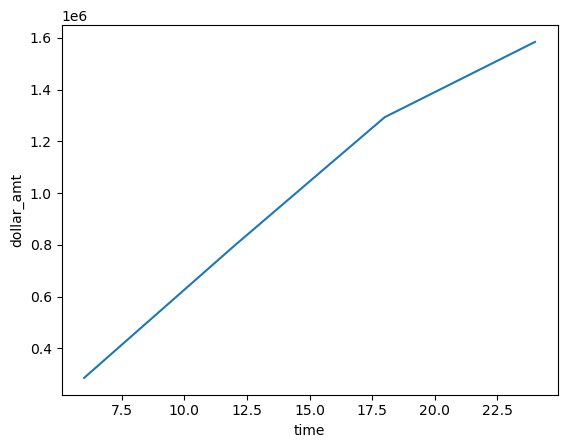

In [16]:
sns.lineplot(t_df, x='time',y='dollar_amt')

# Assuming we dont change our targetting strategy, there is a a linear trend from above

Using OLS: Total Future Value can be calculated for other time frames like 30 Months etc. 
Also since only variable is present, we dont need to do any additional analysis like correlation, VIF, Condition Index etc.

In [19]:
from sklearn.linear_model import LinearRegression

In [36]:
X= t_df['time'].values
y= t_df['dollar_amt'].values

In [40]:
X = np.array(t_df.time).reshape(-1, 1)
y= np.array(t_df.dollar_amt).reshape(-1, 1)

In [41]:
 reg = LinearRegression().fit(X,y)

In [43]:
print('coefficient of determination R2 : ',reg.score(X, y))

coefficient of determination R2 :  0.9857725153360335


From the above, we can say that the fit is really good for predicting future values

Its also a univariate OLS which requires input in months 

In [61]:
dollar_pred =  reg.predict(np.array([6,12,18,24,30,36,42]).reshape(-1,1))

In [62]:
dollar_pred

array([[ 330924.688],
       [ 770271.076],
       [1209617.464],
       [1648963.852],
       [2088310.24 ],
       [2527656.628],
       [2967003.016]])

In [63]:
t_df_with_predictions = t_df.copy()

In [64]:
t_df_with_predictions

,time,dollar_amt
0,6,285499.63
1,12,796556.19
2,18,1293322.41
3,24,1584398.85


In [76]:
new_rows = {'time':[30,36,42],'dollar_amt':[np.nan,np.nan,np.nan]}

In [78]:
t_df_with_predictions = pd.concat([t_df_with_predictions,pd.DataFrame(new_rows)], ignore_index=True)

In [85]:
t_df_with_predictions['dollar_pred'] = pd.DataFrame(dollar_pred)

In [86]:
t_df_with_predictions

,time,dollar_amt,dollar_pred
0,6,285499.63,330924.688
1,12,796556.19,770271.076
2,18,1293322.41,1209617.464
3,24,1584398.85,1648963.852
4,30,NaN,2088310.240
5,36,NaN,2527656.628
6,42,NaN,2967003.016


C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

<Axes: xlabel='time', ylabel='value'>

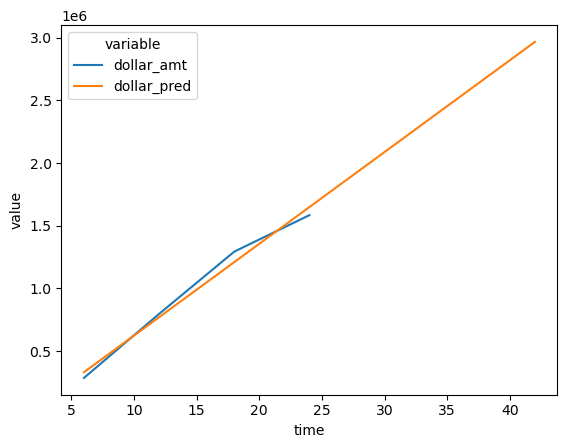

In [89]:
sns.lineplot(x='time', y='value', hue='variable', data=pd.melt(t_df_with_predictions, ['time']))

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

<Axes: xlabel='time', ylabel='value'>

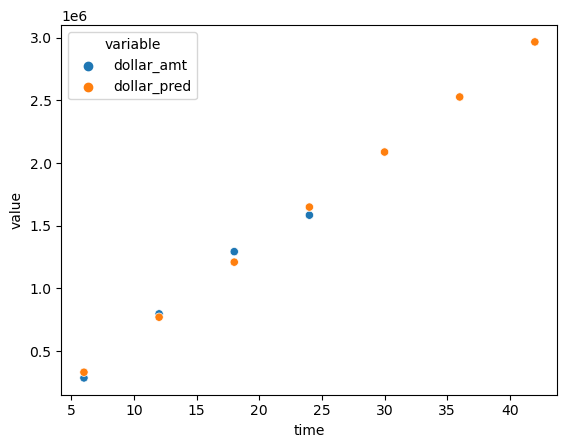

In [90]:
sns.scatterplot(x='time', y='value', hue='variable', data=pd.melt(t_df_with_predictions, ['time']))

In [91]:
print('predicted future value of donation after 30 months: $',  reg.predict(np.array([[30]])))

predicted future value of donation after 30 months: $ [[2088310.24]]


In [ ]:
# Change approach based on the $ data 

From the data, the dollar variables  have been incorporated into the 